# Project 2

## Molecular Data

The QM7 dataset consists of 7165 organic molecules, each of which is composed of up to 23 atoms.


In [1]:
%matplotlib inline
import scipy
import scipy.io
import numpy as np
import torch
import torchvision,torchvision.transforms
import sqlite3
import matplotlib
from matplotlib import pyplot as plt

data = scipy.io.loadmat('qm7.mat')

 The 3d coordinates of each atom in each molecule are available in the variable R. It is an array of size 7165×23×3
containing for each molecule and atom a triplet representing the 3d coordinates.

In [2]:
data['R'][0,0,:] # eg coordinates of first atom in first molecule

array([ 1.886438  , -0.00464873, -0.00823921], dtype=float32)

The variable Z is an array
of size 7165×23 which gives for each molecule and atom of the molecule the corresponding atomic number.
An atomic number of 1 corresponds to a hydrogen atom (H), the number 6 corresponds to carbon (C), the
numbers 7 and 8 to nitrogen (N) and oxygen (O) respectively, and finally, the number 16 corresponds to
sulfur (S). If the number is zero, then it indicates that there is no atom at this index, and the corresponding
3d coordinate should therefore be ignored.

In [3]:
data['Z'][0,0] # first atom of first molecule is carbon

6.0

 This allows for representing in the same array molecules of
different sizes. In addition to these geometrical features of the molecule, the dataset also provides for
each molecule its atomization energy (computed via quantum-chemical simulation). These atomization
energy values are stored in the variable T, an array of size 7165.

In [4]:
data['T'][0] # atomization energy values of first molecule

array([ -417.96,  -712.42,  -564.21, ..., -1662.1 , -1782.01, -1919.  ],
      dtype=float32)

We want to be able to visualize the molecules. For this we are utilizing 3D plotting in Matplotlib.



In [5]:
cov_radii = { # covalent radii in pm
    1.:31.,
    6.:77.2,
    7.:71.,
    8.:66.,
    16.:105.,
}
kindness = 5 # this is cheating though :(

# to atomic units (Bohr radius)
for (k, v) in cov_radii.items():
    cov_radii[k] = (v + kindness) / 52.9

# helper function
def bond(i:int, j:int, coords, ans) -> bool:
    """
    Returns True if and only if the atoms should bond given their atomic numbers and coordinates.
    """
    # if the distance between two atoms is less than the sum
    # of their covalent radii they are considered bonded
    r = cov_radii[ans[i]] + cov_radii[ans[j]]
    dist = coords[i] - coords[j]
    return  np.dot(dist, dist) < r*r #dist^2 < r^2

# visualization
def visualize(ax, molecule_index:int):
    """
    Creates an image of the molecule at a give index on the given 3DAxis object.
    """

    atoms_present = data['Z'][molecule_index] != 0
    coords = data['R'][molecule_index][atoms_present] # atom coordinates
    ans = data['Z'][molecule_index][atoms_present] # atomic nrs

    # draw atoms
    for (name, nr, m) in [("H", 1, 'o'), ("C", 6, 's'), ("N", 7, 'd'), ("O", 8, '*'), ("S", 16, "^")]:
        elem = coords[ans==nr]
        ax.scatter(elem[:,0], elem[:,1], elem[:,2], s=50, marker=m, label=name)

    # draw lines between atoms that are close enough
    for i in range(len(coords)): # compare all combinations of atoms
        for j in range(i+1, len(coords)):
            if(bond(i, j, coords, ans)):
                # connect with a line
                ax.plot([coords[i][0], coords[j][0]],
                        [coords[i][1], coords[j][1]],
                        zs=[coords[i][2], coords[j][2]],
                        color='y'
                        )
    

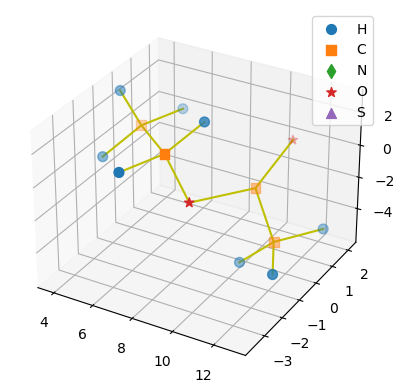

In [6]:
from collections.abc import Iterable
from itertools import cycle

def quickly_show_mol(i:int):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    visualize(ax, i)
    ax.legend()
    plt.show()

def show_mols(indices:Iterable, columns:int=3, size=3):

    fig = plt.figure()
    rows = int(np.ceil(len(indices) / columns))
    fig.set_size_inches(size*columns, size*rows)
    
    for (ax_i, i) in enumerate(indices, start=1):
        ax = fig.add_subplot(rows, columns, ax_i, projection='3d')
        visualize(ax, i)
    plt.show()

# Example usage of visualize.
quickly_show_mol(800)

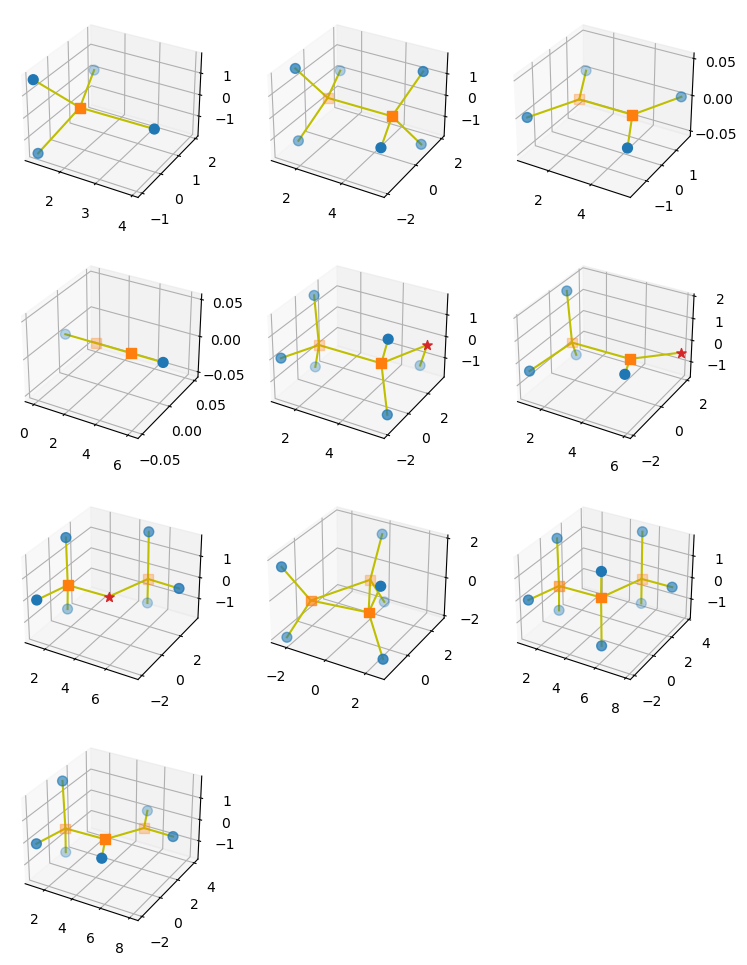

In [7]:
show_mols(range(10))


In [8]:
#Vector Representation

def molecule_representation(molecule_index):
    """
    Generates the vector representation for a given molecule.
    """
    atoms_present = data['Z'][molecule_index] != 0
    atom_numbers = data['Z'][molecule_index][atoms_present]  # Atomic numbers
    representation = np.zeros(5)  # Initialize with zeros for each atom type
    
    for atom_number in atom_numbers:
        representation += atom_one_hot_encoding(atom_number)
    
    return representation

num_molecules = data['Z'].shape[0]  # Total number of molecules

for molecule_index in range(num_molecules):
    representation = molecule_representation(molecule_index)
    print(f"Vector representation for molecule {molecule_index}:")
    print(representation)
    print("-------------------")


Vector representation for molecule 0:
[4. 1. 0. 0. 0.]
-------------------
Vector representation for molecule 1:
[6. 2. 0. 0. 0.]
-------------------
Vector representation for molecule 2:
[4. 2. 0. 0. 0.]
-------------------
Vector representation for molecule 3:
[2. 2. 0. 0. 0.]
-------------------
Vector representation for molecule 4:
[6. 2. 0. 1. 0.]
-------------------
Vector representation for molecule 5:
[4. 2. 0. 1. 0.]
-------------------
Vector representation for molecule 6:
[6. 2. 0. 1. 0.]
-------------------
Vector representation for molecule 7:
[6. 3. 0. 0. 0.]
-------------------
Vector representation for molecule 8:
[8. 3. 0. 0. 0.]
-------------------
Vector representation for molecule 9:
[6. 3. 0. 0. 0.]
-------------------
Vector representation for molecule 10:
[4. 3. 0. 0. 0.]
-------------------
Vector representation for molecule 11:
[5. 2. 1. 0. 0.]
-------------------
Vector representation for molecule 12:
[7. 2. 1. 0. 0.]
-------------------
Vector representation 

Vector representation for molecule 2678:
[10.  5.  0.  2.  0.]
-------------------
Vector representation for molecule 2679:
[8. 5. 0. 2. 0.]
-------------------
Vector representation for molecule 2680:
[6. 5. 0. 2. 0.]
-------------------
Vector representation for molecule 2681:
[6. 5. 0. 2. 0.]
-------------------
Vector representation for molecule 2682:
[4. 5. 0. 2. 0.]
-------------------
Vector representation for molecule 2683:
[8. 5. 0. 2. 0.]
-------------------
Vector representation for molecule 2684:
[10.  5.  0.  2.  0.]
-------------------
Vector representation for molecule 2685:
[12.  6.  0.  1.  0.]
-------------------
Vector representation for molecule 2686:
[10.  6.  0.  1.  0.]
-------------------
Vector representation for molecule 2687:
[10.  7.  0.  0.  0.]
-------------------
Vector representation for molecule 2688:
[10.  6.  0.  1.  0.]
-------------------
Vector representation for molecule 2689:
[12.  6.  0.  1.  0.]
-------------------
Vector representation for mol

Vector representation for molecule 3935:
[7. 5. 1. 1. 0.]
-------------------
Vector representation for molecule 3936:
[6. 4. 2. 1. 0.]
-------------------
Vector representation for molecule 3937:
[6. 4. 2. 1. 0.]
-------------------
Vector representation for molecule 3938:
[7. 5. 1. 1. 0.]
-------------------
Vector representation for molecule 3939:
[7. 5. 1. 1. 0.]
-------------------
Vector representation for molecule 3940:
[7. 5. 1. 1. 0.]
-------------------
Vector representation for molecule 3941:
[11.  5.  1.  1.  0.]
-------------------
Vector representation for molecule 3942:
[9. 6. 1. 0. 0.]
-------------------
Vector representation for molecule 3943:
[14.  7.  0.  0.  0.]
-------------------
Vector representation for molecule 3944:
[5. 5. 1. 1. 0.]
-------------------
Vector representation for molecule 3945:
[11.  5.  1.  1.  0.]
-------------------
Vector representation for molecule 3946:
[9. 5. 1. 1. 0.]
-------------------
Vector representation for molecule 3947:
[11.  5.

Vector representation for molecule 5249:
[8. 4. 2. 1. 0.]
-------------------
Vector representation for molecule 5250:
[8. 4. 2. 1. 0.]
-------------------
Vector representation for molecule 5251:
[6. 4. 2. 1. 0.]
-------------------
Vector representation for molecule 5252:
[9. 5. 1. 1. 0.]
-------------------
Vector representation for molecule 5253:
[8. 4. 2. 1. 0.]
-------------------
Vector representation for molecule 5254:
[7. 4. 1. 2. 0.]
-------------------
Vector representation for molecule 5255:
[9. 5. 1. 1. 0.]
-------------------
Vector representation for molecule 5256:
[8. 4. 2. 1. 0.]
-------------------
Vector representation for molecule 5257:
[7. 4. 1. 2. 0.]
-------------------
Vector representation for molecule 5258:
[7. 5. 1. 1. 0.]
-------------------
Vector representation for molecule 5259:
[9. 6. 1. 0. 0.]
-------------------
Vector representation for molecule 5260:
[6. 4. 2. 1. 0.]
-------------------
Vector representation for molecule 5261:
[7. 4. 1. 2. 0.]
------

Vector representation for molecule 6538:
[4. 4. 2. 0. 1.]
-------------------
Vector representation for molecule 6539:
[2. 4. 2. 0. 1.]
-------------------
Vector representation for molecule 6540:
[6. 4. 2. 0. 1.]
-------------------
Vector representation for molecule 6541:
[8. 4. 2. 0. 1.]
-------------------
Vector representation for molecule 6542:
[7. 6. 1. 0. 0.]
-------------------
Vector representation for molecule 6543:
[8. 4. 2. 0. 1.]
-------------------
Vector representation for molecule 6544:
[10.  4.  2.  0.  1.]
-------------------
Vector representation for molecule 6545:
[10.  4.  2.  0.  1.]
-------------------
Vector representation for molecule 6546:
[8. 4. 0. 2. 1.]
-------------------
Vector representation for molecule 6547:
[8. 4. 0. 2. 1.]
-------------------
Vector representation for molecule 6548:
[10.  4.  0.  2.  1.]
-------------------
Vector representation for molecule 6549:
[6. 4. 0. 2. 1.]
-------------------
Vector representation for molecule 6550:
[10.  4.

ridge regression objective: J(w) = E[(w⊤x − t)
2 + λ∥w∥
2
]

closed form solution: w = (Σxx + λI)
−1Σxt

In [9]:
lambdas = [0, 0.1, 0.2, 0.5, 1, 2, 4, 8, 16, 32, 64]

def ridge_reg(x,y):
    # center
    x_cent = x - x.mean(axis=0)
    y_cent = y - y.mean(axis=0)
    # var
    auto_cov = x_cent@x_cent.T
    cros_cov = x_cent@y_cent
    # regress
    w_norm = []
    w = []
    for lambd in lambdas:
        w_norm.append(np.linalg.norm(np.linalg.inv(auto_cov + lambd * np.identity(auto_cov.shape[0]))@cros_cov))
        w.append(np.linalg.inv(auto_cov + lambd * np.identity(auto_cov.shape[0]))@cros_cov)

    return w[np.argmin(w_norm)], lambdas[np.argmin(w_norm)]

In [10]:
#Ridge Regression Model
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [11]:
# Generate the feature matrix X and target values y
X = np.array([molecule_representation(i) for i in range(num_molecules)])
y = data['T'].flatten()

In [12]:
#Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
#Ridge regression with different regularization parameters
reg_params = [0.1, 1.0, 10.0]
for reg_param in reg_params:
# Create a Ridge regression model
    ridge_model = Ridge(alpha=reg_param)
# Fit the model to the training data
ridge_model.fit(X_train, y_train)

# Predict the atomization energies for the test data
y_pred = ridge_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Ridge regression with regularization parameter {reg_param}:")
print(f"Mean squared error: {mse}")
print("-------------------")

Ridge regression with regularization parameter 10.0:
Mean squared error: 416.4361253453244
-------------------


In [14]:
#Choose the best regularization parameter based on the lowest mean squared error
#Final Ridge regression model with the best regularization parameter
best_reg_param = 1.0
ridge_model = Ridge(alpha=best_reg_param)
ridge_model.fit(X_train, y_train)

#Predict the atomization energies for the test data
y_pred = ridge_model.predict(X_test)

#Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Final Ridge regression model with regularization parameter {best_reg_param}:")
print(f"Mean squared error: {mse}")
print("-------------------")

Final Ridge regression model with regularization parameter 1.0:
Mean squared error: 414.3735503167025
-------------------


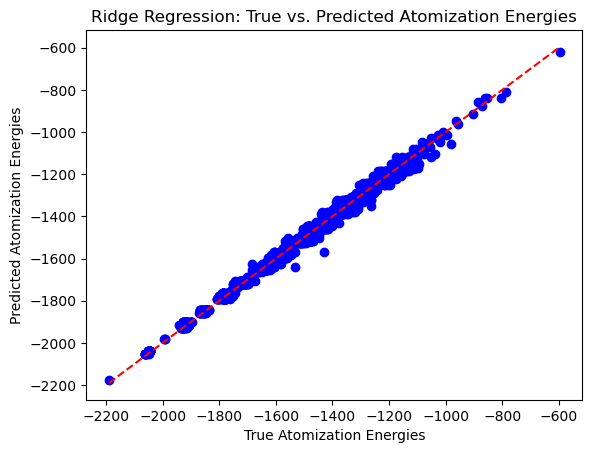

In [15]:
#Visualize the predicted atomization energies vs. true atomization energies
plt.scatter(y_test, y_pred, c='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c='red', linestyle='--')
plt.xlabel('True Atomization Energies')
plt.ylabel('Predicted Atomization Energies')
plt.title('Ridge Regression: True vs. Predicted Atomization Energies')
plt.show()

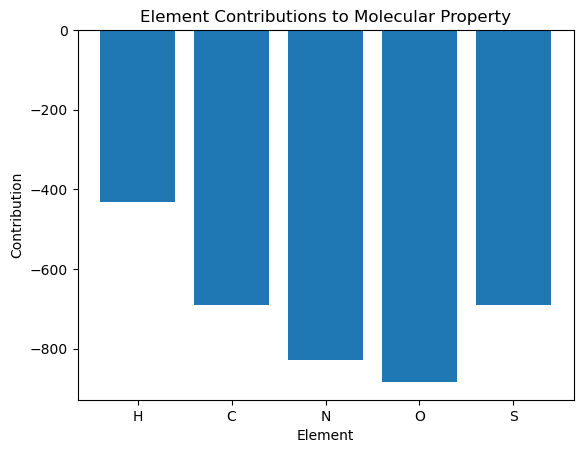

In [16]:
#Deeper Insights 
'''This code will calculate the absolute contributions of each element in the molecule to the overall prediction 
using the weight vector w obtained from the Ridge regression model. It will then visualize the element contributions 
using a bar chart, showing the contribution of each element to the molecular property.'''

# Get the learned weight vector
w = ridge_model.coef_

# Calculate the contributions of each element in the molecule to the overall prediction
element_contributions = np.dot(X, w.T)

# Create a dictionary mapping element numbers to element names
element_names = {1: 'H', 6: 'C', 7: 'N', 8: 'O', 16: 'S'}

# Initialize lists to store element names and their corresponding contributions
element_labels = []
contributions = []

# Iterate over the element contributions and retrieve the element names and their contributions
for element_number, contribution in enumerate(element_contributions):
    if element_number + 1 in element_names:
        element_labels.append(element_names[element_number + 1])
        contributions.append(contribution)

# Visualize the element contributions
plt.bar(element_labels, contributions)
plt.xlabel('Element')
plt.ylabel('Contribution')
plt.title('Element Contributions to Molecular Property')
plt.show()


In [17]:
# Bounding box diagonal of the coords in data['R']
data_diagonal = np.amax(data['R'], axis=(0,1)) - np.amin(data['R'], axis=(0,1))
# No two atoms will ever be further apart than this. 
# We will refrain from computing the maximum distance of any two atoms as the bucket shapes based on this should suffice.
max_distance = np.sqrt(np.dot(data_diagonal, data_diagonal))

def distance_repr(mol_index, bucket_count, variance=1):
    """Representation of the molecule as a vector that measures sums of the distances between atoms in buckets."""
    
    # calculate the bucket dimentions
    bucket_size = max_distance/bucket_count
    bucket_borders = np.arange(0, max_distance, bucket_size)
    bucket_centers = bucket_borders + bucket_size/2

    atom_indices = data['Z'][mol_index] != 0
    dists = scipy.spatial.distance.pdist(data['R'][mol_index][atom_indices])
    # dists = scipy.spatial.distance.squareform(dists) # NxN matrix of all distances from atom to atom

    # now determine bucket values using a gauss function: f(x) = exp(-((x-mu)/sigma)^2) 
    # (normal distribution with factor 1/(sigma*sqrt(2pi)) removed thereby scaling the height to 1)
    phis = np.exp(-0.5 * np.square((dists/variance)[:, np.newaxis] - bucket_centers/variance))

    return np.sum(phis, axis=0)

distance_repr(100, 5)

array([3.01259134e+001, 3.85873825e-001, 1.17220457e-020, 1.86131258e-067,
       1.06229538e-141])

In [18]:
def atom_type_repr(mol_index):
    """Representation of the molecule as a vector that counts pairs for each individual type of pair."""
    count = molecule_representation(mol_index)
    #a = numpy.outer(count) - np.diag(count) # inefficient because we calculate the products twice
    res = []
    for i in range(len(count)):
        res.append((count[i] * count[i] - count[i]) / 2)
        for j in range(i+1, len(count)):
            res.append(count[i] * count[j])

    assert(len(res) == 15) # 5+4+3+2+1 = 15
    return np.array(res)

print(atom_type_repr(100))

[21. 21.  7.  7.  0.  3.  3.  3.  0.  0.  1.  0.  0.  0.  0.]


In [19]:
def atom_pair_feature_map(molecule_index):
    return np.flatten(np.outer(
        distance_repr(molecule_index, 5), 
        atom_type_repr(molecule_index)
    ))